In [1]:
cd ../../

/workspace/SEED-Story


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [25]:
!apt-get install imagemagick -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fontconfig fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gsfonts hicolor-icon-theme imagemagick-6-common imagemagick-6.q16 libaom3
  libavahi-client3 libavahi-common-data libavahi-common3 libcairo2 libcups2
  libdatrie1 libdav1d5 libde265-0 libdjvulibre-text libdjvulibre21
  libfftw3-double3 libfribidi0 libgraphite2-3 libgs9 libgs9-common
  libharfbuzz0b libheif1 libidn12 libijs-0.35 libilmbase25 libjbig2dec0
  libjxr-tools libjxr0 liblcms2-2 liblqr-1-0 libltdl7 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libnuma1
  libopenexr25 libopenjp2-7 libpango-1.0-0 libpangocairo-1.0-0
  libpangoft2-1.0-0 libpaper-utils libpaper1 libpixman-1-0 libthai-data
  libthai0 libwebpdemux2 libwebpmux3 libwmflite-0.2-7 libx265-199
  libxcb-render0 libxrender1 netpbm poppler-data
Suggested pack

In [3]:
!pip install --ignore-installed blinker
!pip install -r requirements.txt
!pip install FPDF
!pip install moviepy
!pip install gtts
!pip install ImageMagick
!pip install mutagen

  Using cached blinker-1.8.2-py3-none-any.whl.metadata (1.6 kB)
Using cached blinker-1.8.2-py3-none-any.whl (9.5 kB)

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
  Using cached accelerate-0.28.0-py3-none-any.whl.metadata (18 kB)
  Using cached deepspeed-0.9.5-py3-none-any.whl
  Using cached diffusers-0.29.2-py3-none-any.whl.metadata (19 kB)
  Using cached easyocr-1.7.1-py3-none-any.whl.metadata (11 kB)
  Using cached flask-3.0.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached huggingface_hub-0.24.2-py3-none-any.whl.metadata (13 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached matplotlib-3.7.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.7 kB)
  Using cached pandas-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached peft-0.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached pytorch_lightning-2.2.1-py3-n

In [3]:
# flake8: noqa
import hydra
from omegaconf import OmegaConf
import torch
import os
import re
import pyrootutils
from PIL import Image, ImageDraw, ImageFont
import json
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, EulerDiscreteScheduler


BOI_TOKEN = '<img>'
EOI_TOKEN = '</img>'
IMG_TOKEN = '<img_{:05d}>'

device = 'cuda:0'
dtype = torch.float16
dtype_str = 'fp16'
num_img_in_tokens = 64
num_img_out_tokens = 64
instruction_prompt = '{instruction}'

tokenizer_cfg_path = 'configs/tokenizer/clm_llama_tokenizer.yaml'
image_transform_cfg_path = 'configs/processer/qwen_448_transform.yaml'
visual_encoder_cfg_path = 'configs/visual_tokenizer/qwen_vitg_448.yaml'

llm_cfg_path = 'configs/clm_models/llama2chat7b_lora.yaml'
agent_cfg_path = 'configs/clm_models/agent_7b_sft.yaml'

adapter_cfg_path = 'configs/detokenizer/detokenizer_sdxl_qwen_vit_adapted.yaml'
discrete_model_cfg_path = 'configs/discrete_model/discrete_identity.yaml'

diffusion_model_path = 'pretrained/stable-diffusion-xl-base-1.0'

save_dir = "output"

tokenizer_cfg = OmegaConf.load(tokenizer_cfg_path)
tokenizer = hydra.utils.instantiate(tokenizer_cfg)

image_transform_cfg = OmegaConf.load(image_transform_cfg_path)
image_transform = hydra.utils.instantiate(image_transform_cfg)

visual_encoder_cfg = OmegaConf.load(visual_encoder_cfg_path)
visual_encoder = hydra.utils.instantiate(visual_encoder_cfg)
visual_encoder.eval().to(device, dtype=dtype)
print('Init visual encoder done')

llm_cfg = OmegaConf.load(llm_cfg_path)
llm = hydra.utils.instantiate(llm_cfg, torch_dtype=dtype_str)
print('Init llm done.')

agent_model_cfg = OmegaConf.load(agent_cfg_path)
agent_model = hydra.utils.instantiate(agent_model_cfg, llm=llm)

agent_model.eval().to(device, dtype=dtype)
print('Init agent model Done')

noise_scheduler = EulerDiscreteScheduler.from_pretrained(diffusion_model_path, subfolder="scheduler")
print('init vae')
vae = AutoencoderKL.from_pretrained(diffusion_model_path, subfolder="vae").to(device, dtype=dtype)
print('init unet')
unet = UNet2DConditionModel.from_pretrained(diffusion_model_path, subfolder="unet").to(device, dtype=dtype)

adapter_cfg = OmegaConf.load(adapter_cfg_path)
adapter = hydra.utils.instantiate(adapter_cfg, unet=unet).to(device, dtype=dtype).eval()
print('Init adapter done')

discrete_model_cfg = OmegaConf.load(discrete_model_cfg_path)
discrete_model = hydra.utils.instantiate(discrete_model_cfg).to(device).eval()
print('Init discrete model done')

adapter.init_pipe(vae=vae,
                  scheduler=noise_scheduler,
                  visual_encoder=visual_encoder,
                  image_transform=image_transform,
                  discrete_model=discrete_model,
                  dtype=dtype,
                  device=device)

print('Init adapter pipe done')
boi_token_id = tokenizer.encode(BOI_TOKEN, add_special_tokens=False)[0]
eoi_token_id = tokenizer.encode(EOI_TOKEN, add_special_tokens=False)[0]


def read_jsonl_to_dict(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            # Each line is a valid JSON object
            json_object = json.loads(line)
            data.append(json_object)
    return data


def add_subtitle(original_image, text):
    # Calculate the size of the new image
    text_height = 80  # Height of the black bar for the text
    new_image_size = (original_image.width, original_image.height + text_height)

    # Create a new image with a black background
    new_image = Image.new("RGB", new_image_size, "black")
    # Paste the original image onto the new image
    new_image.paste(original_image, (0, 0))

    # Prepare the new image for drawing
    draw = ImageDraw.Draw(new_image)

    # Specify the font size and font path
    font_size = 14  # Adjust font size as needed
    # font = ImageFont.truetype(font_path, font_size)

    # Manually split the text into two lines
    line1, line2 = text[:len(text) // 2], text[len(text) // 2:]

    # Update the position for the first line of text to ensure both lines are centered vertically
    text_position_line1 = (10, original_image.height + (text_height - font_size) // 2)

    # Define the text color
    text_color = "white"

    # Add the first line of text to the new image
    draw.text(text_position_line1, line1, fill=text_color)

    # Adjust the position for the second line of text, based on the height of the first line
    text_position_line2 = (10, text_position_line1[1] + font_size)

    # Add the second line of text to the new image
    draw.text(text_position_line2, line2, fill=text_color)

    return new_image



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Load ckpt of qwen visual encoder
missing keys:  0 unexpected keys: 0
Init visual encoder done


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Length of tokenizer and resize embedding: 32066
peft config:  LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=16, target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj', 'gate_proj', 'down_proj', 'up_proj'], lora_alpha=32, lora_dropout=0.05, fan_in_fan_out=False, bias='none', modules_to_save=['input_layernorm', 'post_attention_layernorm', 'norm'], init_lora_weights=True, layers_to_transform=None, layers_pattern=None)
trainable params: 303,194,112 || all params: 6,779,199,488 || trainable%: 4.4724176141547405
Init llm done.
agent model, missing keys:  0 unexpected keys: 0
Init agent model Done
init vae
init unet
missing keys:  0 unexpected keys: 0
Init adapter done
Init discrete model done
Init adapter pipe done


In [54]:
from PIL import Image, ImageDraw, ImageFont
import textwrap
import os

def create_comic_page(images, texts, images_per_row=4, font_path=None, font_size=100, spacing=50):
    """ Create a single comic page with images and captions styled to be more visually appealing """
    
    width, height = 512, 512  # Fixed image size
    text_height = 60  # Height reserved for text
    total_images = len(images)
    rows = (total_images // images_per_row) + (total_images % images_per_row > 0)
    grid_image = Image.new('RGB', (images_per_row * (width + spacing) - spacing, rows * (height + text_height + spacing) - spacing), 'black')

    draw = ImageDraw.Draw(grid_image)
    font = ImageFont.truetype(font_path, font_size) if font_path else ImageFont.load_default(font_size)

    # Paste images and add text in a grid with spacing
    for index, (img, text) in enumerate(zip(images, texts)):
        img = img.resize((width, height))
        x = (index % images_per_row) * (width + spacing)
        y = (index // images_per_row) * (height + text_height + spacing)
        grid_image.paste(img, (x, y))

        # Calculate text wrapping and positioning
        wrapped_text = textwrap.fill(text, width=50)  # Adjust width based on your font size and image width
        text_y = y + height + 5  # Small margin between image and text
        draw.multiline_text((x, text_y), wrapped_text, font=font, fill="white", align='center', spacing=4)

    return grid_image

def create_comic(images, texts, images_per_page=6, images_per_row=3, font_path=None, font_size=20, spacing=20):
    """ Create multiple comic pages from lists of images and texts """
    pages = []
    for i in range(0, len(images), images_per_page):
        page_images = images[i:i + images_per_page]
        page_texts = texts[i:i + images_per_page]
        comic_page = create_comic_page(page_images, page_texts, images_per_row, font_path, font_size, spacing)
        pages.append(comic_page)
    return pages

def gen_image(output):
    image_embeds_gen = output['img_gen_feat']
    images_gen = adapter.generate(image_embeds=output['img_gen_feat'], num_inference_steps=50)
    return images_gen, image_embeds_gen

def main(image_path, question, story_len = 8, window_size = 8, text_id = 1):

    output_texts, generated_images = [], []

    image = Image.open(image_path).convert('RGB')
                
    agent_model.llm.base_model.model.use_kv_cache_head = False
    image_tensor = image_transform(image).unsqueeze(0).to(device, dtype=dtype)
    
    image_tokens = BOI_TOKEN + ''.join([IMG_TOKEN.format(int(item)) for item in range(num_img_in_tokens)]) + EOI_TOKEN
    
    prompt = instruction_prompt.format_map({'instruction': question + image_tokens})
    
    input_ids = tokenizer.encode(prompt, add_special_tokens=False)
    input_ids = [tokenizer.bos_token_id] + input_ids
    
    boi_idx = input_ids.index(boi_token_id)
    eoi_idx = input_ids.index(eoi_token_id)
    
    input_ids = torch.tensor(input_ids).to(device, dtype=torch.long).unsqueeze(0)
    
    ids_cmp_mask = torch.zeros_like(input_ids, dtype=torch.bool)
    
    ids_cmp_mask[0, boi_idx + 1:eoi_idx] = True
    embeds_cmp_mask = torch.tensor([True]).to(device, dtype=torch.bool)
    
    with torch.no_grad():
        image_embeds = visual_encoder(image_tensor)
    output = agent_model.generate(tokenizer=tokenizer,
                                  input_ids=input_ids,
                                  image_embeds=image_embeds,
                                  embeds_cmp_mask=embeds_cmp_mask,
                                  ids_cmp_mask=ids_cmp_mask,
                                  max_new_tokens=500,
                                  num_img_gen_tokens=num_img_out_tokens)
    text = re.sub(r'\s*<[^>]*>\s*', ' ', output['text']).strip()
    if '[INST]' in text:
        text = text.split('[INST]')[1]
    output_texts.append(text)

    while output['has_img_output'] and image_embeds.shape[0] < story_len:
        
        images_gen, image_embeds_gen = gen_image(output)
        
        original_image = images_gen[0]    
        generated_images.append(original_image)

    
        image_embeds = torch.cat((image_embeds, image_embeds_gen), dim=0)
        
        if text_id >= story_len - 1:
            break
    
        prompt = prompt + text + image_tokens
        text_id += 1
    
        input_ids = tokenizer.encode(prompt, add_special_tokens=False)
        while image_embeds.shape[0] > window_size:
            eoi_prompt_idx = prompt.index(EOI_TOKEN)
            prompt = prompt[eoi_prompt_idx + len(EOI_TOKEN) + len('[INST]'):]
            image_embeds = image_embeds[1:]
            input_ids = tokenizer.encode(prompt, add_special_tokens=False)
    
        input_ids = [tokenizer.bos_token_id] + input_ids
    
        boi_idx = torch.where(torch.tensor(input_ids) == boi_token_id)[0].tolist()
        eoi_idx = torch.where(torch.tensor(input_ids) == eoi_token_id)[0].tolist()
    
        input_ids = torch.tensor(input_ids).to(device, dtype=torch.long).unsqueeze(0)
    
        ids_cmp_mask = torch.zeros_like(input_ids, dtype=torch.bool)
    
        for i in range(image_embeds.shape[0]):
            ids_cmp_mask[0, boi_idx[i] + 1:eoi_idx[i]] = True
        embeds_cmp_mask = torch.tensor([True] * image_embeds.shape[0]).to(device, dtype=torch.bool)
    
        output = agent_model.generate(tokenizer=tokenizer,
                                      input_ids=input_ids,
                                      image_embeds=image_embeds,
                                      embeds_cmp_mask=embeds_cmp_mask,
                                      ids_cmp_mask=ids_cmp_mask,
                                      max_new_tokens=500,
                                      num_img_gen_tokens=num_img_out_tokens)
        text = re.sub(r'\s*<[^>]*>\s*', ' ', output['text']).strip()

        if '[INST]' in text:
            text = text.split('[INST]')[1]
        output_texts.append(text)

    return generated_images, output_texts

In [59]:
import gradio as gr
from PIL import Image
import gradio as gr
from PIL import Image
from fpdf import FPDF
from gtts import gTTS
import os
import numpy as np 

from moviepy.editor import ImageClip, AudioFileClip, concatenate_videoclips, TextClip, CompositeVideoClip
from gtts import gTTS
import os
from PIL import Image, ImageDraw, ImageFont
import textwrap




def images_to_pdf(images):
    pdf = FPDF()
    for image in images:
        image_path = "tmp/temp_image.jpg"
        image.save(image_path)
        pdf.add_page()
        pdf.image(image_path, x=10, y=10, w=180)
    pdf_path = "tmp/comic.pdf"
    pdf.output(pdf_path)
    return pdf_path

def draw_text_on_image(image, text, font_size=20, max_width=30):
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Try to use a nicer font, fallback to default if not available
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    # Wrap text
    wrapped_text = textwrap.fill(text, width=max_width)
    lines = wrapped_text.split('\n')

    # Calculate total text height
    line_heights = [font.getbbox(line)[3] - font.getbbox(line)[1] for line in lines]
    total_text_height = sum(line_heights)

    # Calculate starting Y position to place text at the bottom
    padding = 10
    y = height - total_text_height - padding

    # Draw a semi-transparent rectangle for the entire text area
    rectangle_position = (0, y - padding, width, height)
    draw.rectangle(rectangle_position, fill=(0, 0, 0, 128))  # Semi-transparent black

    for line in lines:
        # Get line width
        bbox = font.getbbox(line)
        line_width = bbox[2] - bbox[0]

        # Calculate x position to center this line
        x = (width - line_width) // 2

        # Draw the text
        draw.text((x, y), line, font=font, fill="white")

        # Move to the next line
        y += line_heights[lines.index(line)]

    return image
    
def create_video(images, texts, fps=24):
    clips = []
    temp_files = []

    for i, (image, text) in enumerate(zip(images, texts)):
        # Draw text on image
        image = image.resize((512,512))
        
        image_with_text = draw_text_on_image(image.copy(), text)
        
        # Save image
        image_path = f"tmp/temp_image_{i}.jpg"
        image_with_text.save(image_path)
        temp_files.append(image_path)

        # Generate audio
        audio_path = f"tmp/temp_audio_{i}.mp3"
        tts = gTTS(text=text, lang='en')
        tts.save(audio_path)
        temp_files.append(audio_path)


        audio_clip = AudioFileClip(audio_path)
        duration = audio_clip.duration

        # Create video clip
        img_clip = ImageClip(image_path).set_duration(duration)
        video_clip = img_clip.set_audio(audio_clip)
        clips.append(video_clip)
        
    # Concatenate clips
    final_clip = concatenate_videoclips(clips, method="compose")

    # Write video file
    video_path = "tmp/comic_video.mp4"
    try:
        final_clip.write_videofile(video_path, codec="libx264", audio_codec="aac", fps=fps)
    except Exception as e:
        print(f"Error writing video file: {e}")
        # Clean up temporary files
        for file in temp_files:
            if os.path.exists(file):
                os.remove(file)
        raise  # Re-raise the exception after cleanup

    # Clean up temporary files
    for file in temp_files:
        if os.path.exists(file):
            os.remove(file)
    
    return video_path

# Define the main function for Gradio to use
def app(image_path, question):
    font_path = None
    
    generated_images, output_texts = main(image_path, question, story_len = 8, window_size = 8, text_id = 1)
    
    comic_pages = create_comic(generated_images, output_texts, images_per_page=6, images_per_row=2, font_path=font_path, font_size=20, spacing=30)   

    pdf_path = images_to_pdf(comic_pages)
    video_path = create_video(generated_images, output_texts, fps=24)

    return [comic.convert("RGB") for comic in comic_pages], pdf_path, video_path

def show_image(images, index):
    if index < 0 or index >= len(images):
        return None, index
    return images[index], index


def next_image(images, index):
    new_index = (index + 1) % len(images)
    return images[new_index], new_index


def prev_image(images, index):
    new_index = (index - 1) % len(images)
    return images[new_index], new_index


with gr.Blocks() as demo:
    with gr.Row():
        image_input = gr.Image(type="filepath", label="Image Path")
        scenario_input = gr.Textbox(label="Enter your scenario:")

    generate_button = gr.Button("Generate Comic")

    image_output = gr.Image(label="Generated Image", elem_id="image_output", height=2000)
    pdf_output = gr.File(label="Generated PDF")
    video_output = gr.Video(label="Generated Video")
    index = gr.State(0)
    generated_images = gr.State([])

    generate_button.click(
        app,
        inputs=[image_input, scenario_input],
        outputs=[generated_images, pdf_output, video_output]
    ).then(
        show_image,
        inputs=[generated_images, index],
        outputs=[image_output, index]
    )

    with gr.Row():
        prev_button = gr.Button("Previous")
        next_button = gr.Button("Next")

    prev_button.click(
        prev_image,
        inputs=[generated_images, index],
        outputs=[image_output, index]
    )

    next_button.click(
        next_image,
        inputs=[generated_images, index],
        outputs=[image_output, index]
    )


demo.launch(share=True)


Running on local URL:  http://127.0.0.1:7867

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
Running on public URL: https://c1918d0ea3b4fff1c9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Moviepy - Building video tmp/comic_video.mp4.
MoviePy - Writing audio in comic_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video tmp/comic_video.mp4



Moviepy - Done !
Moviepy - video ready tmp/comic_video.mp4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

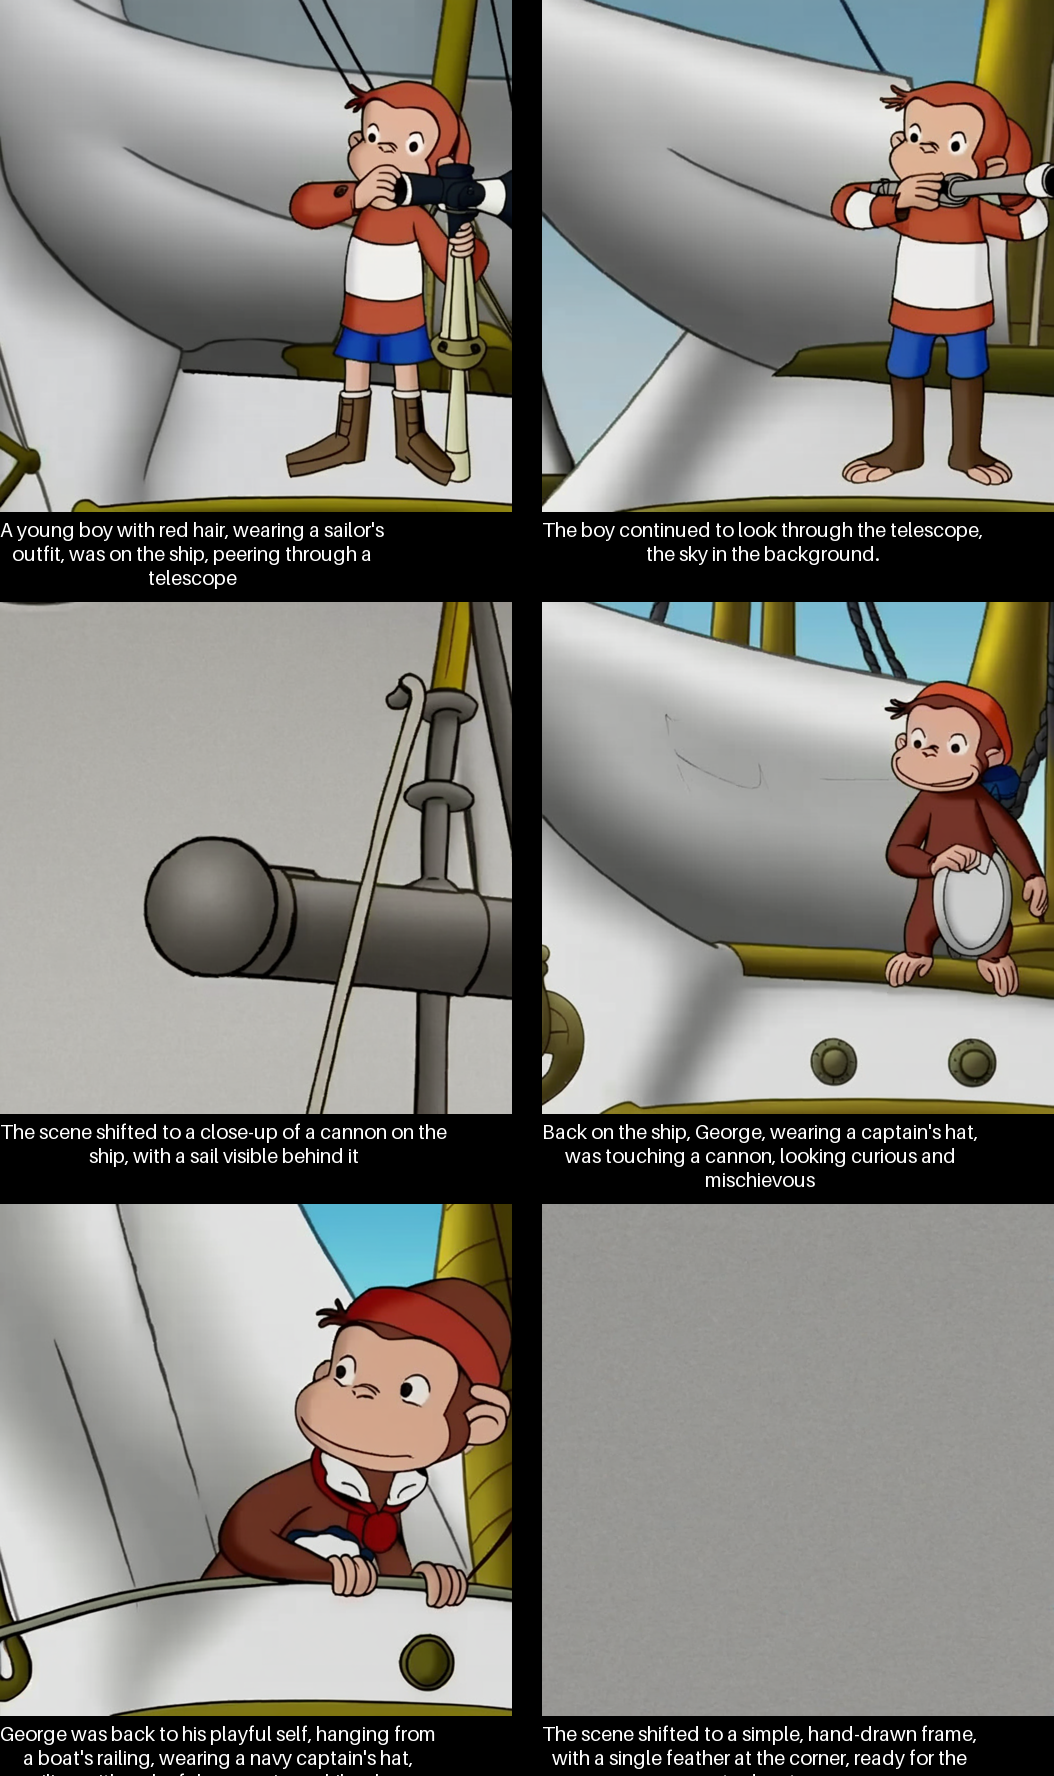

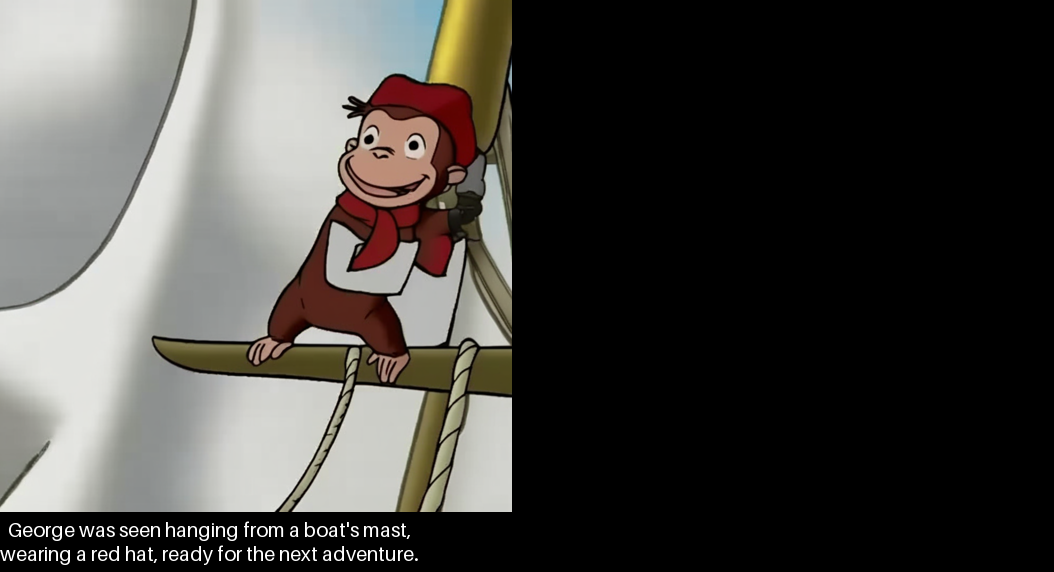

In [56]:
# Example usage assuming generated_images and output_texts are predefined lists
font_path = None #"workspace/SEED-Story/manga-temple.ttf"  # Specify the path to a TTF font file

image_path = "test_image/pirate_ship.jpg"
question = "George found himself in Pirate ship, in the middle of the sea"

generated_images, output_texts = main(image_path, question, story_len = 8, window_size = 8, text_id = 1)

comic_pages = create_comic(generated_images, output_texts, images_per_page=6, images_per_row=2, font_path=font_path, font_size=20, spacing=30)

# Save and display the comic pages
for idx, page in enumerate(comic_pages):
    page_path = f'comic_page_{idx + 1}.jpg'
    #page.save(page_path)
    page.show()

In [51]:
create_video(generated_images, output_texts)

Moviepy - Building video tmp/comic_video.mp4.
MoviePy - Writing audio in comic_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video tmp/comic_video.mp4



Moviepy - Done !
Moviepy - video ready tmp/comic_video.mp4


'tmp/comic_video.mp4'

In [206]:
from mutagen.mp3 import MP3 
from PIL import Image 
from pathlib import Path 
import os 
import imageio 
from moviepy import editor 


for i, (image, text) in enumerate(zip(generated_images, output_texts)):
        # Save image
        image_path = f"tmp/temp_image_{i}.jpg"
        image.save(image_path)
        temp_files.append(image_path)

        # Generate audio
        audio_path = f"tmp/temp_audio_{i}.mp3"
        tts = gTTS(text=text, lang='en')
        tts.save(audio_path)
        temp_files.append(audio_path)
        break
    

audio = MP3(audio_path) 
audio_length = audio.info.length 
    
duration = audio_length/1 
imageio.mimsave('images.gif', [image], fps=1/duration) 
  
video = editor.VideoFileClip("images.gif") 
audio = editor.AudioFileClip(audio_path) 
final_video = video.set_audio(audio) 
final_video.write_videofile(fps=60, codec="libx264", filename="tmp/video.mp4") 

chunk:   0%|          | 1/772 [12:52<165:31:41, 772.89s/it, now=None]

Moviepy - Building video tmp/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3



chunk:   0%|          | 1/772 [12:53<165:34:05, 773.08s/it, now=None][A

MoviePy - Done.
Moviepy - Writing video tmp/video.mp4



TypeError: must be real number, not NoneType

In [196]:
import imageio 
from moviepy import editor 
from pathlib import Path 
import os 

In [195]:
final_clip.write_videofile(video_path, codec="libx264", audio_codec="aac", fps=24)

Moviepy - Building video /tmp/comic_video.mp4.
MoviePy - Writing audio in comic_videoTEMP_MPY_wvf_snd.mp3


chunk:   0%|          | 0/772 [00:00<?, ?it/s, now=None]

IndexError: index -100001 is out of bounds for axis 0 with size 0

In [189]:
create_video(generated_images, output_texts)

Moviepy - Building video /tmp/comic_video.mp4.
MoviePy - Writing audio in comic_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /tmp/comic_video.mp4

Error writing video file: must be real number, not NoneType


TypeError: must be real number, not NoneType

In [193]:
fps

1

In [168]:
generated_images

[<PIL.Image.Image image mode=RGB size=1024x1024>,
 <PIL.Image.Image image mode=RGB size=1024x1024>,
 <PIL.Image.Image image mode=RGB size=1024x1024>,
 <PIL.Image.Image image mode=RGB size=1024x1024>,
 <PIL.Image.Image image mode=RGB size=1024x1024>,
 <PIL.Image.Image image mode=RGB size=1024x1024>,
 <PIL.Image.Image image mode=RGB size=1024x1024>]